# 8.2 Training a convnet from scratch on a small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a
few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training—1,000 for validation, and 1,000 for testing.

 In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. You’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get you to a classification accuracy of about 70%. At that point, the main issue will be overfitting. Then we’ll introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, you’ll improve the network to reach an accuracy of 80-85%.
 
 In the next section, we’ll review two more essential techniques for applying deep
learning to small datasets: *feature extraction with a pretrained network* (which will get you to an accuracy of 90% to 96%) and *fine-tuning a pretrained network* (this will get you to a final accuracy of 97%). Together, these three strategies—training a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pretrained model—will constitute your future toolbox for tackling the problem of performing image classification with small datasets.

## 8.2.1 The relevance of deep learning for small-data problems

You’ll sometimes hear that deep learning only works when lots of data is available.
This is valid in part: one fundamental characteristic of deep learning is that it can find
interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are
available. This is especially true for problems where the input samples are very highdimensional, like images.

 What qualifies as "enough samples" to train a model is relative—relative to the size and depth of the
network you’re trying to train, for starters. It isn’t possible to train a convnet to solve a
complex problem with just a few tens of samples, but a few hundred can potentially
suffice if the model is small and well regularized and the task is simple. Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still
yield reasonable results despite a relative lack of data, without the need for any custom
feature engineering. You’ll see this in action in this section.

 What’s more, deep-learning models are by nature highly repurposable: you can
take, say, an image-classification or speech-to-text model trained on a large-scale dataset
and reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pretrained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That’s what you’ll do in the next section. Let’s
start by getting your hands on the data.

## 8.2.2 Downloading the data

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when
convnets weren’t mainstream. You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data (you’ll need to create a Kaggle account if you don’t already
have one—don’t worry, the process is painless).

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and
is 543 MB (compressed). After downloading and uncompressing it, you’ll create a new
dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1000 samples of each class.

### Copying images to training, validation, and test directories

In [1]:
import os, shutil, pathlib

#Path to the directory where the original dataset was uncompressed
original_dir = pathlib.Path("/kaggle/input/dogs-vs-cats/train/train")
# Directory where we'll store our smaller dataset
new_base_dir = pathlib.Path("/kaggle/working/cats_and_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range (start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)


So you do indeed have 2,000 training images, 1,000 validation images, and 2,000 test
images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an
appropriate measure of success. 

## 8.2.3 Building your network

You’ll reuse the same general structure: the convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. But because we’re dealing with bigger images and a more complex problem, we’ll make your network larger, accordingly: it will have two more `Conv2D` and `MaxPooling2D` stages. This serves both to augment the capacity of the network and to further reduce the size of the feature maps so they aren’t overly large when you reach the `Flatten` layer. Here, because you start from inputs of size 180 × 180 (a somewhat arbitrary choice), you end up with feature maps of size 7 × 7 just before the `Flatten` layer.

<div class="alert alert-block alert-info">
The depth of the feature maps progressively increases in the network
(from 32 to 256), whereas the size of the feature maps decreases (from 180 ×
180 to 7 × 7). This is a pattern you’ll see in almost all convnets.
</div>

Because you’re attacking a binary-classification problem, you’ll end the network with a
single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will encode the
probability that the network is looking at one class or the other.

One last small difference: we will start the model with a `Rescaling` layer, which will
rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range.
### Instantiating a small convnet for dogs vs. cats classification

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

### Configuring the model for training

In [5]:
from keras import optimizers
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['acc'])

## 8.2.4 Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floating-point tensors before being fed into the network. Currently, the data sits on a drive as
JPEG files, so the steps for getting it into the network are roughly as follows:
1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (we'll use 180 × 180).
5. Pack them into batches (we'll use batches of 32 images).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these
steps automatically. In particular, Keras features the utility function `image_dataset_from_
directory()`, which lets you quickly set up a data pipeline that can automatically turn
image files on disk into batches of preprocessed tensors. This is what we’ll use here.

Calling `image_dataset_from_directory(directory)` will first list the subdirectories of `directory` and assume each one contains images from one of our classes. It will
then index the image files in each subdirectory. Finally, it will create and return a
`tf.data.Dataset` object configured to read these files, shuffle them, decode them to
tensors, resize them to a shared size, and pack them into batches.

### Using `image_dataset_from_directory` to read images

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Understanding TensorFlow `Dataset` objects**

TensorFlow makes available the `tf.data` API to create efficient input pipelines for
machine learning models. Its core class is `tf.data.Dataset`.

A `Dataset` object is an iterator: you can use it in a for loop. It will typically return
batches of input data and labels. You can pass a `Dataset` object directly to the `fit()`
method of a Keras model.

The `Dataset` class handles many key features that would otherwise be cumbersome
to implement yourself—in particular, asynchronous data prefetching (preprocessing
the next batch of data while the previous one is being handled by the model, which
keeps execution flowing without interruptions).

The `Dataset` class also exposes a functional-style API for modifying datasets. Here’s
a quick example: let’s create a `Dataset` instance from a NumPy array of random numbers. We’ll consider 1,000 samples, where each sample is a vector of size 16:

In [7]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
# The from_tensor_slices() class method can be used to create a Dataset from a NumPy array, or a tuple or dict of NumPy arrays.
dataset = tf.data.Dataset.from_tensor_slices(random_numbers) 

At first, our dataset just yields single samples:

In [8]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


We can use the `.batch()` method to batch the data:

In [10]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


More broadly, we have access to a range of useful dataset methods, such as
- `.shuffle(buffer_size)`—Shuffles elements within a buffer
- `.prefetch(buffer_size)`—Prefetches a buffer of elements in GPU memory to achieve better device utilization.
- `.map(callable)`—Applies an arbitrary transformation to each element of the dataset (the function `callable`, which expects to take as input a single element yielded by the dataset).

The `.map() method`, in particular, is one that you will use often. Here’s an example.
We’ll use it to reshape the elements in our toy dataset from shape `(16,)` to shape `(4, 4)`:

In [11]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Let’s look at the output of one of these `Dataset` objects: it yields batches of 180 × 180
RGB images (shape `(32, 180, 180, 3)`) and integer labels (shape `(32,)`). There are
32 samples in each batch (the batch size).

### Displaying the shapes of the data and labels yielded by the `Dataset`

In [12]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape (32, 180, 180, 3)
labels batch shape: (32,)


Let’s fit the model on our dataset. We’ll use the `validation_data` argument in `fit()`
to monitor validation metrics on a separate `Dataset` object.

 Note that we’ll also use a `ModelCheckpoint` callback to save the model after each
epoch. We’ll configure it with the path specifying where to save the file, as well as the
arguments `save_best_only=True` and `monitor="val_loss"`: they tell the callback to
only save a new file (overwriting any previous one) when the current value of the
`val_loss` metric is lower than at any previous time during training. This guarantees
that your saved file will always contain the state of the model corresponding to its best-performing training epoch, in terms of its performance on the validation data. As a
result, we won’t have to retrain a new model for a lower number of epochs if we start
overfitting: we can just reload our saved file.

### Fitting the model using a `Dataset`

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset, 
    epochs=30, 
    validation_data=validation_dataset, 
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 11s 72ms/step - loss: 0.6895 - acc: 0.5180 - val_loss: 0.6895 - val_acc: 0.5090
Epoch 2/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6772 - acc: 0.5765 - val_loss: 0.6814 - val_acc: 0.5350
Epoch 3/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6591 - acc: 0.6135 - val_loss: 0.7116 - val_acc: 0.5250
Epoch 4/30
63/63 [==============================] - 4s 59ms/step - loss: 0.6444 - acc: 0.6265 - val_loss: 0.7803 - val_acc: 0.5110
Epoch 5/30
63/63 [==============================] - 4s 59ms/step - loss: 0.6226 - acc: 0.6635 - val_loss: 0.6343 - val_acc: 0.6380
Epoch 6/30
63/63 [==============================] - 4s 58ms/step - loss: 0.5879 - acc: 0.6860 - val_loss: 0.6781 - val_acc: 0.5860
Epoch 7/30
63/63 [==============================] - 5s 70ms/step - loss: 0.5649 - acc: 0.7115 - val_loss: 0.6623 - val_acc: 0.6320
Epoch 8/30
63/63 [==============================] - 4s 60ms/step - loss: 0.5466 - 

### *Displaying curves of loss and accuracy during training*

In [15]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

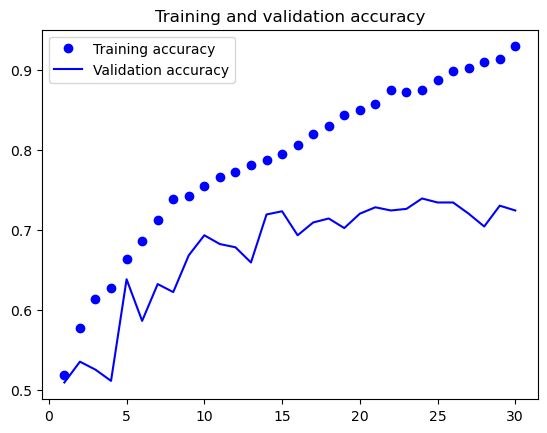

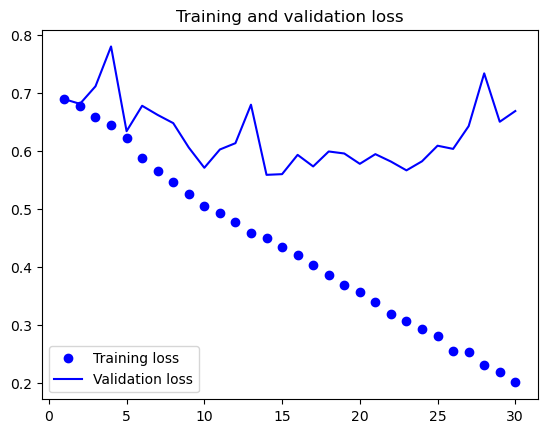

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly
over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%.
The validation loss reaches its minimum after only ten epochs and then stalls, whereas
the training loss keeps decreasing linearly as training proceeds.

Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate
it as it was before it started overfitting.

### Evaluating the model on the test set

In [17]:
test_model = keras.models.load_model("/kaggle/working/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 46ms/step - loss: 0.5539 - acc: 0.7205
Test accuracy: 0.720


Because you have relatively few training samples (2,000), overfitting will be your
number-one concern. You already know about a number of techniques that can help
mitigate overfitting, such as dropout and weight decay (L2 regularization). In the next section, we will work with a new one, specific to computer vision and used almost universally
when processing images with deep-learning models: *data augmentation*. 

## 8.2.5 Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable
to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would
never overfit. Data augmentation takes the approach of generating more training data
from existing training samples, by *augmenting* the samples via a number of random
transformations that yield believable-looking images. The goal is that at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data and generalize better.

 In Keras, this can be done by adding a number of *data augmentation* layers at the
start of your model. Let’s get started with an example: the following Sequential model
chains several random image transformations. In our model, we’d include it right
before the `Rescaling` layer.

###  Define a data augmentation stage to add to an image model

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

These are just a few of the options available (for more, see the Keras documentation).
Let’s quickly go over this code:
- `RandomFlip("horizontal")`—Applies horizontal flipping to a random 50% of
the images that go through it
- `RandomRotation(0.1)`—Rotates the input images by a random value in the range
[–10%, +10%] (these are fractions of a full circle—in degrees, the range would
be [–36 degrees, +36 degrees])
- `RandomZoom(0.2)`—Zooms in or out of the image by a random factor in the
range [-20%, +20%]

Let’s look at the augmented images.

### Displaying some randomly augmented training images

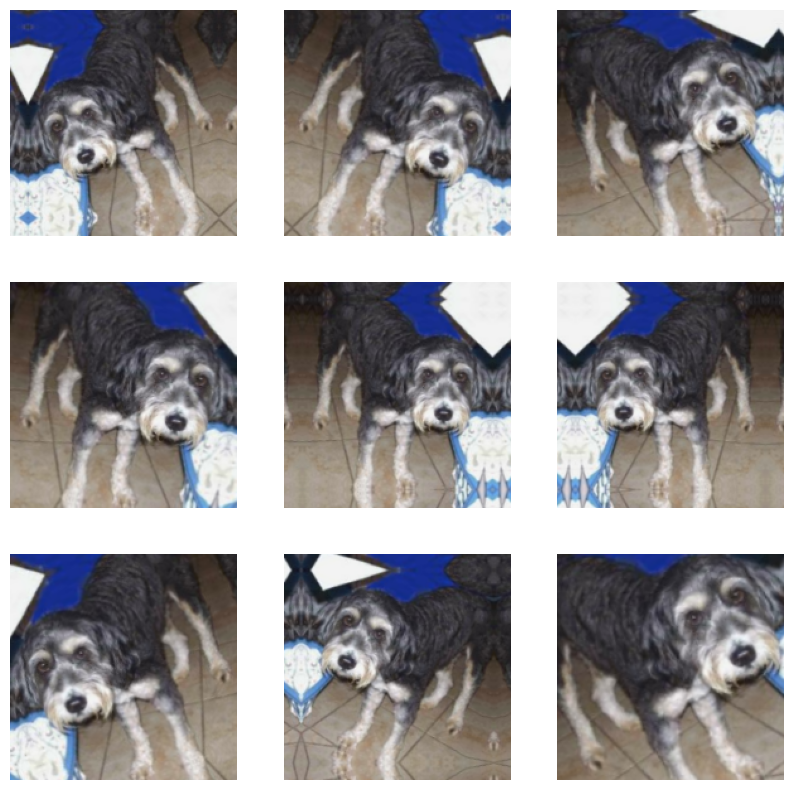

In [20]:
plt.figure(figsize=(10, 10))
# We can use take(N) to only sample N batches from the dataset. 
# This is equivalent to inserting a break in the loop after the Nth batch.
for images, _ in train_dataset.take(1):
    for i in range(9):
        # Apply the augmentation stage to the batch of images.
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        # Display the first image in the output batch. 
        # For each of the nine iterations, this is a different augmentation of the same image.
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

If you train a new network using this data-augmentation configuration, the network
will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not
be enough to completely get rid of overfitting. To further fight overfitting, you’ll also
add a `Dropout` layer to your model, right before the densely connected classifier.

 One last thing you should know about random image augmentation layers: just
like `Dropout`, they’re inactive during inference (when we call `predict()` or `evaluate()`).
During evaluation, our model will behave just the same as when it did not include
data augmentation and dropout.

### Defining a new convnet that includes image augmentation and dropout

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Training the regularized convnet

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 61ms/step - loss: 0.7068 - accuracy: 0.4910 - val_loss: 0.6926 - val_accuracy: 0.5010
Epoch 2/100
63/63 [==============================] - 4s 63ms/step - loss: 0.6929 - accuracy: 0.5330 - val_loss: 0.6885 - val_accuracy: 0.5040
Epoch 3/100
63/63 [==============================] - 4s 60ms/step - loss: 0.6898 - accuracy: 0.5330 - val_loss: 0.6746 - val_accuracy: 0.5750
Epoch 4/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6715 - accuracy: 0.6100 - val_loss: 0.7378 - val_accuracy: 0.5340
Epoch 5/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6565 - accuracy: 0.6375 - val_loss: 0.6510 - val_accuracy: 0.5950
Epoch 6/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6246 - accuracy: 0.6500 - val_loss: 0.6055 - val_accuracy: 0.6600
Epoch 7/100
63/63 [==============================] - 5s 71ms/step - loss: 0.6175 - accuracy: 0.6555 - val_loss: 0.6132 - val_accuracy: 0.6570
Epoch 

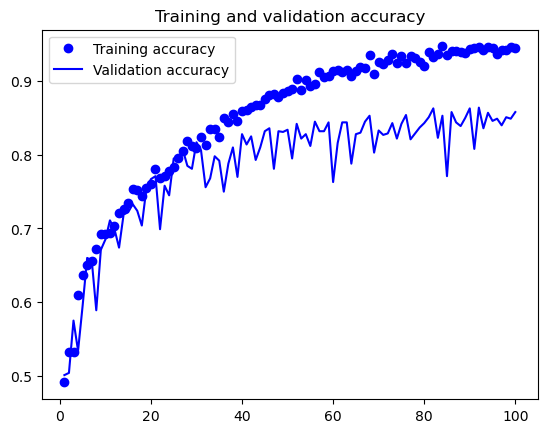

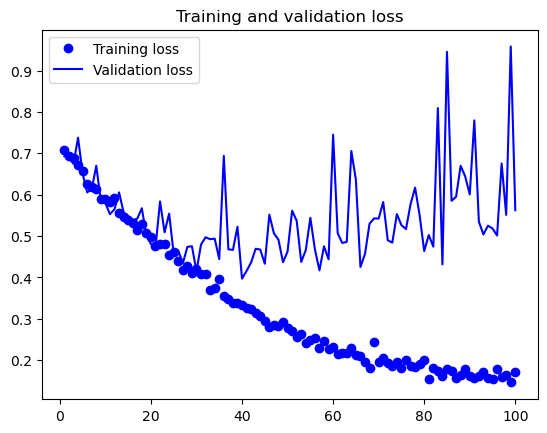

In [23]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Evaluating the model on the test set

In [24]:
test_model = keras.models.load_model(
    "/kaggle/working/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 33ms/step - loss: 0.4366 - accuracy: 0.8175
Test accuracy: 0.817


Make sure you download the saved file (convnet_from_scratch_with_augmentation.keras),
as we will use it for some experiments in the next chapter.

By further tuning the model’s configuration (such as the number of filters per
convolution layer, or the number of layers in the model), we might be able to get an
even better accuracy, likely up to 90%. But it would prove difficult to go any higher
just by training our own convnet from scratch, because we have so little data to work
with. As a next step to improve our accuracy on this problem, we’ll have to use a pretrained model, which is the focus of the next two sections. 